In [1]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy.stats import skew, kurtosis

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone, is_classifier
from sklearn.model_selection._split import check_cv

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inlineimport gc
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/dex/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
UsageError: unrecognized arguments: gc


In [3]:
class UniqueTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, axis=1, accept_sparse=False):
        if axis == 0:
            raise NotImplementedError('axis is 0! Not implemented!')
        if accept_sparse:
            raise NotImplementedError('accept_sparse is True! Not implemented!')
        self.axis = axis
        self.accept_sparse = accept_sparse
        
    def fit(self, X, y=None):
        _, self.unique_indices_ = np.unique(X, axis=self.axis, return_index=True)
        return self
    
    def transform(self, X, y=None):
        return X[:, self.unique_indices_]


class StatsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, stat_funs=None, verbose=0, n_jobs=-1, pre_dispatch='2*n_jobs'):
        self.stat_funs = stat_funs
        self.verbose = verbose
        self.n_jobs = n_jobs
        self.pre_dispatch = pre_dispatch
    
    def _get_stats(self, row):
        stats = []
        for fun in self.stat_funs:
            stats.append(fun(row))
        return stats

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        parallel = Parallel(
            n_jobs=self.n_jobs,
            pre_dispatch=self.pre_dispatch,
            verbose=self.verbose
        )
        stats_list = parallel(delayed(self._get_stats)(X[i_smpl, :]) for i_smpl in range(len(X)))
        return np.array(stats_list)
    
class LnTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.sign(X)*np.log1p(np.abs(X))   


class ClassifierTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator=None, n_classes=2, cv=3):
        self.estimator = estimator
        self.n_classes = n_classes
        self.cv = cv
    
    def _get_labels(self, y):
        y_labels = np.zeros(len(y))
        y_us = np.sort(np.unique(y))
        step = int(len(y_us) / self.n_classes)
        
        for i_class in range(self.n_classes):
            if i_class + 1 == self.n_classes:
                y_labels[y >= y_us[i_class * step]] = i_class
            else:
                y_labels[
                    np.logical_and(
                        y >= y_us[i_class * step],
                        y < y_us[(i_class + 1) * step]
                    )
                ] = i_class
        return y_labels
        
    def fit(self, X, y):
        y_labels = self._get_labels(y)
        cv = check_cv(self.cv, y_labels, classifier=is_classifier(self.estimator))
        self.estimators_ = []
        
        for train, _ in cv.split(X, y_labels):
            self.estimators_.append(
                clone(self.estimator).fit(X[train], y_labels[train])
            )
        return self
    
    def transform(self, X, y=None):
        cv = check_cv(self.cv, y, classifier=is_classifier(self.estimator))
        
        X_prob = np.zeros((X.shape[0], self.n_classes))
        X_pred = np.zeros(X.shape[0])
        
        for estimator, (_, test) in zip(self.estimators_, cv.split(X)):
            X_prob[test] = estimator.predict_proba(X[test])
            X_pred[test] = estimator.predict(X[test])
        return np.hstack([X_prob, np.array([X_pred]).T])


class _StatFunAdaptor:
    
    def __init__(self, stat_fun, *funs, **stat_fun_kwargs):
        self.stat_fun = stat_fun
        self.funs = funs
        self.stat_fun_kwargs = stat_fun_kwargs

    def __call__(self, x):
        x = x[x != 0]
        for fun in self.funs:
            x = fun(x)
        if x.size == 0:
            return -99999
        return self.stat_fun(x, **self.stat_fun_kwargs)


def diff2(x):
    return np.diff(x, n=2)


def get_stat_funs():
    """
    Previous version uses lambdas.
    """
    stat_funs = []
    
    stats = [len, np.min, np.max, np.median, np.std, skew, kurtosis] + 19 * [np.percentile]
    stats_kwargs = [{} for i in range(7)] + [{'q': i} for i in np.linspace(0.05, 0.95, 19)]

    for stat, stat_kwargs in zip(stats, stats_kwargs):
        stat_funs.append(_StatFunAdaptor(stat,**stat_kwargs))
        stat_funs.append(_StatFunAdaptor(stat, np.diff, **stat_kwargs))
        stat_funs.append(_StatFunAdaptor(stat, diff2, **stat_kwargs))
        stat_funs.append(_StatFunAdaptor(stat, np.unique, **stat_kwargs))
        stat_funs.append(_StatFunAdaptor(stat, np.unique, np.diff, **stat_kwargs))
        stat_funs.append(_StatFunAdaptor(stat, np.unique, diff2, **stat_kwargs))
    return stat_funs


def get_rfc():
    return RandomForestClassifier(
        n_estimators=100,
        max_features=0.5,
        max_depth=None,
        max_leaf_nodes=270,
        min_impurity_decrease=0.0001,
        random_state=123,
        n_jobs=-1
    )

def get_input():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    y_train_log = np.log1p(train['target'])
    id_test = test['ID']
    del test['ID']
    del train['ID']
    del train['target']
    return train.values, y_train_log.values, test.values, id_test.values


pipe = Pipeline(
    [
        ('vt', VarianceThreshold(threshold=0.0)),
        ('ut', UniqueTransformer()),
        ('fu', FeatureUnion(
                [
                    ('pca', PCA(n_components=100)),
                    ('ct-2', ClassifierTransformer(get_rfc(), n_classes=2, cv=5)),
                    ('ct-3', ClassifierTransformer(get_rfc(), n_classes=3, cv=5)),
                    ('ct-4', ClassifierTransformer(get_rfc(), n_classes=4, cv=5)),
                    ('ct-5', ClassifierTransformer(get_rfc(), n_classes=5, cv=5)),
                    ('st', StatsTransformer(stat_funs=get_stat_funs(), verbose=2))
                ]
            )
        ),
        ('ln', LnTransformer())
    ]
)

In [4]:
X_train, y_train_log, X_test, id_test = get_input()
pipe.fit(X_train, y_train_log)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1404 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 4459 out of 4459 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 3644 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 4459 out of 4459 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1012 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3042 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5872 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 9522 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 13972 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 19242 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 25312 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 32202 t

In [5]:
ss = StandardScaler()
ss.fit(np.vstack([X_train,X_test]))
X_train = np.round(ss.transform(X_train).astype(float),6)
X_test = np.round(ss.transform(X_test).astype(float),6)

In [6]:
traindf = pd.DataFrame(data=X_train,columns=['s' + str(s) for s in range(X_train.shape[1])])
testdf = pd.DataFrame(data=X_test,columns=['s' + str(s) for s in range(X_test.shape[1])])

In [7]:
def GPClusterX(data):
    v = pd.DataFrame()
    v["s0"] = np.tanh(np.where(data["s107"]>0, (((data["s110"]) + (np.minimum(((-1.0)), ((2.0)))))/2.0), ((((5.0)) > (data["s139"]))*1.) )) 
    v["s1"] = np.tanh(np.minimum((((8.61502456665039062))), ((np.tanh((np.minimum((((3.65845537185668945))), ((((data["s100"]) * ((((((np.tanh((-1.0))) + (0.0))) + (0.0))/2.0)))))))))))) 
    v["s2"] = np.tanh(((((((((data["s105"]) + (((((((-1.0*((data["s112"])))) + ((-1.0*((((data["s112"]) / 2.0))))))/2.0)) * 2.0)))/2.0)) / 2.0)) + (((data["s139"]) + (data["s136"]))))/2.0)) 
    v["s3"] = np.tanh(((((((data["s139"]) + ((((data["s105"]) + (((data["s139"]) / 2.0)))/2.0)))/2.0)) + (np.minimum((((((data["s136"]) > ((((data["s112"]) + (2.0))/2.0)))*1.))), ((data["s136"])))))/2.0)) 
    v["s4"] = np.tanh(((((((((data["s136"]) - ((((data["s136"]) > (((data["s136"]) / 2.0)))*1.)))) - (data["s112"]))) - ((((data["s112"]) + (-1.0))/2.0)))) + (data["s112"]))) 
    v["s5"] = np.tanh((((-2.0) + (data["s117"]))/2.0)) 
    v["s6"] = np.tanh(((data["s110"]) - (-1.0))) 
    v["s7"] = np.tanh(np.where(((((data["s110"]) / 2.0)) / 2.0)>0, ((data["s136"]) * (((((data["s136"]) * 2.0)) / 2.0))), ((data["s107"]) * (((data["s136"]) * (data["s112"])))) )) 
    v["s8"] = np.tanh(((np.maximum(((data["s139"])), ((data["s112"])))) * (((np.maximum(((data["s112"])), ((((data["s110"]) * (data["s139"])))))) * (((data["s139"]) / 2.0)))))) 
    v["s9"] = np.tanh((((3.0) < (-2.0))*1.)) 
    v["s10"] = np.tanh(((((data["s105"]) * (data["s136"]))) - (data["s116"]))) 
    v["s11"] = np.tanh(((data["s100"]) - ((((data["s103"]) > (data["s107"]))*1.)))) 
    v["s12"] = np.tanh((((((-1.0*((data["s112"])))) * (((((data["s136"]) * (((data["s136"]) / 2.0)))) * (data["s136"]))))) * (data["s136"]))) 
    v["s13"] = np.tanh(np.tanh((((np.maximum(((np.where(data["s101"]>0, data["s116"], (6.0) ))), ((((-1.0) * 2.0))))) * 2.0)))) 
    v["s14"] = np.tanh((((((-2.0) / 2.0)) + (np.maximum(((data["s105"])), (((((-1.0) + (2.0))/2.0))))))/2.0)) 
    v["s15"] = np.tanh((((data["s103"]) + (np.where(data["s104"]>0, (((data["s104"]) < (data["s103"]))*1.), (((-1.0) > ((((-1.0) + (np.minimum(((1.0)), ((data["s116"])))))/2.0)))*1.) )))/2.0)) 
    v["s16"] = np.tanh(((np.maximum(((((np.minimum(((-2.0)), ((data["s110"])))) + (data["s107"])))), (((((((((data["s116"]) + (-1.0))/2.0)) / 2.0)) / 2.0))))) * (data["s110"]))) 
    v["s17"] = np.tanh((((((-3.0) > (data["s109"]))*1.)) + ((((-3.0) > (((((1.0) / 2.0)) / 2.0)))*1.)))) 
    v["s18"] = np.tanh((((((np.minimum(((data["s38"])), ((data["s38"])))) * (data["s38"]))) + (((((-1.0*((data["s112"])))) + (np.minimum(((data["s38"])), (((-1.0*(((-1.0*((data["s112"])))))))))))/2.0)))/2.0)) 
    v["s19"] = np.tanh((((((data["s116"]) + (data["s40"]))/2.0)) + (np.minimum(((np.minimum((((((-2.0) < (data["s40"]))*1.))), ((((data["s0"]) + (data["s103"]))))))), ((data["s40"])))))) 
    v["s20"] = np.tanh(((np.minimum((((4.0))), ((data["s112"])))) * 2.0)) 
    v["s21"] = np.tanh((((data["s122"]) + (((np.maximum(((data["s119"])), ((data["s116"])))) + (data["s122"]))))/2.0)) 
    v["s22"] = np.tanh(((data["s41"]) + (np.maximum(((data["s76"])), ((np.maximum(((((data["s41"]) + (data["s76"])))), ((((((data["s69"]) + (data["s76"]))) + (data["s69"]))))))))))) 
    v["s23"] = np.tanh(((np.minimum(((np.minimum(((np.tanh((np.tanh(((((((data["s136"]) * 2.0)) + (data["s119"]))/2.0))))))), (((((1.34242451190948486)) * 2.0)))))), ((data["s112"])))) * 2.0)) 
    v["s24"] = np.tanh(((((((np.where(data["s118"]>0, data["s118"], ((data["s157"]) / 2.0) )) * 2.0)) - (data["s77"]))) / 2.0)) 
    v["s25"] = np.tanh(np.where(data["s69"]>0, ((np.tanh(((((3.0) + (data["s258"]))/2.0)))) / 2.0), 0.0 )) 
    v["s26"] = np.tanh(((3.0) + (data["s122"]))) 
    v["s27"] = np.tanh(np.maximum(((np.where(np.maximum(((((data["s64"]) + (data["s14"])))), ((data["s64"])))>0, ((data["s64"]) * 2.0), data["s19"] ))), (((((-1.0*((data["s79"])))) - (data["s19"])))))) 
    v["s28"] = np.tanh(np.where(((data["s119"]) + (((np.tanh((data["s119"]))) + (data["s121"]))))>0, (((((data["s122"]) < ((((data["s122"]) < (data["s119"]))*1.)))*1.)) * 2.0), data["s122"] )) 
    v["s29"] = np.tanh(((((np.minimum(((np.where(data["s131"]>0, (((data["s11"]) > (data["s136"]))*1.), np.maximum(((data["s131"])), ((data["s49"]))) ))), (((((data["s49"]) > (data["s136"]))*1.))))) * 2.0)) * 2.0)) 
    v["s30"] = np.tanh(np.minimum(((3.0)), ((((data["s155"]) * (np.tanh((3.0)))))))) 
    v["s31"] = np.tanh(((((np.minimum(((((data["s70"]) - (data["s136"])))), ((data["s138"])))) - (data["s32"]))) + (np.where(data["s136"]>0, ((data["s70"]) - (data["s14"])), data["s138"] )))) 
    v["s32"] = np.tanh((-1.0*((((data["s157"]) - (np.maximum(((np.where(data["s157"]>0, data["s148"], np.maximum(((data["s148"])), ((((data["s148"]) * 2.0)))) ))), ((((((-1.0) * 2.0)) * 2.0)))))))))) 
    v["s33"] = np.tanh(((((-1.0*((data["s252"])))) < (np.minimum(((((data["s246"]) - (1.0)))), ((data["s246"])))))*1.)) 
    v["s34"] = np.tanh(((((((data["s3"]) - (data["s136"]))) - (((data["s115"]) + (((data["s136"]) * (data["s115"]))))))) + ((((data["s29"]) + (data["s137"]))/2.0)))) 
    v["s35"] = np.tanh(np.minimum((((((((((data["s152"]) + (data["s151"]))/2.0)) - (data["s157"]))) + ((((data["s151"]) + (data["s151"]))/2.0))))), (((((data["s122"]) < (((data["s151"]) / 2.0)))*1.))))) 
    v["s36"] = np.tanh(np.maximum(((((np.maximum(((data["s246"])), ((data["s108"])))) * (((data["s222"]) - (data["s108"])))))), ((((((((data["s108"]) + (data["s246"]))/2.0)) + (data["s258"]))/2.0))))) 
    v["s37"] = np.tanh((((np.maximum(((np.maximum(((data["s122"])), ((((((data["s152"]) * (data["s118"]))) * (data["s148"]))))))), ((data["s152"])))) + (data["s158"]))/2.0)) 
    v["s38"] = np.tanh(((data["s88"]) * ((((((1.0) - (((data["s13"]) / 2.0)))) > (data["s93"]))*1.)))) 
    v["s39"] = np.tanh((((((((np.tanh((((((-1.0) * (np.tanh(((2.0)))))) + (np.minimum(((data["s8"])), ((data["s107"])))))))) / 2.0)) / 2.0)) + (data["s21"]))/2.0)) 
    v["s40"] = np.tanh((((data["s93"]) < (((np.minimum(((np.tanh((data["s27"])))), ((np.where(data["s93"]>0, data["s121"], 2.0 ))))) * 2.0)))*1.)) 
    v["s41"] = np.tanh((((((data["s22"]) * (1.0))) + ((((0.0) < ((-1.0*((data["s13"])))))*1.)))/2.0)) 
    v["s42"] = np.tanh(np.maximum(((data["s121"])), ((((((data["s155"]) * 2.0)) - (((data["s157"]) * 2.0))))))) 
    v["s43"] = np.tanh(np.where(data["s78"]>0, ((((data["s84"]) - (data["s95"]))) * 2.0), np.maximum(((((((data["s95"]) * (data["s84"]))) - (data["s79"])))), ((data["s24"]))) )) 
    v["s44"] = np.tanh(((((np.maximum(((np.where((((((data["s101"]) > (data["s121"]))*1.)) + (data["s101"]))>0, (3.0), data["s77"] ))), ((data["s77"])))) + (data["s151"]))) * 2.0)) 
    v["s45"] = np.tanh(np.maximum((((((((data["s31"]) + (data["s18"]))/2.0)) * (data["s19"])))), ((np.minimum(((((((data["s18"]) - (data["s22"]))) + (data["s64"])))), ((data["s102"]))))))) 
    v["s46"] = np.tanh(((((data["s121"]) * 2.0)) - (np.tanh((-1.0))))) 
    v["s47"] = np.tanh(((((((data["s117"]) > (data["s145"]))*1.)) < (((data["s151"]) - (data["s139"]))))*1.)) 
    v["s48"] = np.tanh(np.tanh((((np.minimum(((((((1.0) * 2.0)) * (data["s250"])))), ((((-1.0) / 2.0))))) * 2.0)))) 
    v["s49"] = np.tanh(((((data["s170"]) + (data["s188"]))) + (np.minimum(((((np.minimum(((((((-3.0) * 2.0)) * (-1.0)))), ((data["s200"])))) + (data["s170"])))), (((4.0))))))) 
    v["s50"] = np.tanh(((((((data["s104"]) * (data["s0"]))) * 2.0)) * 2.0)) 
    v["s51"] = np.tanh((((-1.0*((((np.maximum(((data["s104"])), ((data["s182"])))) * (data["s104"])))))) + (np.where(data["s212"]>0, data["s128"], data["s104"] )))) 
    v["s52"] = np.tanh((((data["s13"]) + (((data["s222"]) * (np.minimum(((data["s13"])), (((((((((data["s139"]) * (data["s222"]))) + (data["s139"]))) + (3.0))/2.0))))))))/2.0)) 
    v["s53"] = np.tanh(((data["s116"]) * (np.minimum(((((data["s116"]) * ((((np.minimum(((data["s116"])), ((-1.0)))) + (data["s139"]))/2.0))))), ((((data["s118"]) + (data["s116"])))))))) 
    v["s54"] = np.tanh(((((3.0) - (data["s216"]))) * 2.0)) 
    v["s55"] = np.tanh((((((((data["s132"]) * ((((((data["s150"]) + (data["s132"]))/2.0)) * (data["s132"]))))) + (data["s150"]))/2.0)) * (((data["s140"]) - (1.0))))) 
    v["s56"] = np.tanh((((((((((((data["s160"]) + (data["s160"]))/2.0)) * (data["s175"]))) * 2.0)) * ((((data["s124"]) + (data["s160"]))/2.0)))) * (((2.0) - (data["s163"]))))) 
    v["s57"] = np.tanh(((np.minimum(((data["s188"])), ((((((-2.0) * (data["s182"]))) * 2.0))))) + (((data["s128"]) - (np.tanh((data["s176"]))))))) 
    v["s58"] = np.tanh((((((-1.0) < (data["s111"]))*1.)) - (np.tanh((np.tanh((data["s111"]))))))) 
    v["s59"] = np.tanh(((((np.minimum(((((1.0) + (data["s113"])))), ((((((((((data["s107"]) - (data["s40"]))) - (data["s139"]))) * 2.0)) * 2.0))))) * 2.0)) - (data["s139"]))) 
    v["s60"] = np.tanh((((-1.0*((data["s31"])))) * (((np.tanh((data["s98"]))) - (1.0))))) 
    v["s61"] = np.tanh(((((data["s151"]) * (((((((((((data["s139"]) + (data["s139"]))) + (data["s90"]))) + (data["s90"]))) * 2.0)) + (data["s90"]))))) - (data["s15"]))) 
    v["s62"] = np.tanh((((2.0) < (np.maximum(((data["s253"])), (((((((-3.0) > (np.maximum(((1.0)), ((data["s253"])))))*1.)) - (((data["s259"]) / 2.0))))))))*1.)) 
    v["s63"] = np.tanh(((((data["s145"]) * 2.0)) + (((((data["s107"]) + (((np.maximum(((data["s107"])), ((((data["s145"]) + (data["s145"])))))) + (data["s145"]))))) * 2.0)))) 
    return v.sum(axis=1).values*.1

def GPClusterY(data):
    v = pd.DataFrame()
    v["s0"] = np.tanh((((((((((data["s110"]) + (data["s101"]))) + (((data["s136"]) - (data["s107"]))))/2.0)) + (data["s136"]))) + (np.minimum(((data["s136"])), (((-1.0*((data["s112"]))))))))) 
    v["s1"] = np.tanh((((data["s268"]) + ((((((data["s105"]) + (np.tanh((data["s107"]))))/2.0)) + (((data["s116"]) - (data["s107"]))))))/2.0)) 
    v["s2"] = np.tanh(np.maximum(((((((((np.tanh((np.tanh((data["s139"]))))) > (1.0))*1.)) + (data["s105"]))/2.0))), ((data["s136"])))) 
    v["s3"] = np.tanh((((data["s139"]) + (np.tanh((data["s139"]))))/2.0)) 
    v["s4"] = np.tanh(((data["s116"]) + (data["s136"]))) 
    v["s5"] = np.tanh(np.minimum((((((data["s268"]) > (((data["s107"]) + ((((data["s136"]) > (data["s107"]))*1.)))))*1.))), ((data["s136"])))) 
    v["s6"] = np.tanh(((((((data["s136"]) / 2.0)) - (data["s103"]))) * (((np.tanh((((((data["s136"]) / 2.0)) / 2.0)))) - ((((-1.0*((data["s136"])))) * (data["s136"]))))))) 
    v["s7"] = np.tanh((((np.where(((((data["s136"]) + (data["s136"]))) + ((0.26983028650283813)))>0, data["s110"], (((-1.0*((data["s112"])))) * 2.0) )) + ((-1.0*((data["s136"])))))/2.0)) 
    v["s8"] = np.tanh((-1.0*(((((data["s139"]) < (data["s107"]))*1.))))) 
    v["s9"] = np.tanh(((np.where(np.maximum(((np.tanh((data["s271"])))), ((np.maximum(((0.0)), ((data["s136"]))))))>0, data["s271"], ((0.0) + ((-1.0*((data["s103"]))))) )) / 2.0)) 
    v["s10"] = np.tanh(np.minimum(((((((2.0) - (data["s107"]))) + (data["s136"])))), ((np.maximum(((((((((data["s107"]) + (data["s105"]))/2.0)) < (data["s107"]))*1.))), ((data["s136"]))))))) 
    v["s11"] = np.tanh((((data["s139"]) > (np.tanh((2.0))))*1.)) 
    v["s12"] = np.tanh((((((12.41106319427490234)) + (((-3.0) / 2.0)))) * ((((((data["s107"]) * (((data["s112"]) + (3.0))))) + ((-1.0*((data["s110"])))))/2.0)))) 
    v["s13"] = np.tanh(((((((((((2.0) - (data["s112"]))) + (2.0))/2.0)) + (((data["s112"]) * (data["s101"]))))/2.0)) * (data["s112"]))) 
    v["s14"] = np.tanh((((((data["s110"]) < (((((((((data["s110"]) / 2.0)) < (data["s105"]))*1.)) < (data["s103"]))*1.)))*1.)) - (data["s103"]))) 
    v["s15"] = np.tanh(((((data["s103"]) + (((data["s259"]) * (data["s105"]))))) * (np.where(data["s116"]>0, data["s116"], ((((((data["s105"]) + (1.0))/2.0)) + (data["s116"]))/2.0) )))) 
    v["s16"] = np.tanh((-1.0*(((((-1.0*((data["s107"])))) - (np.maximum((((7.0))), ((-2.0))))))))) 
    v["s17"] = np.tanh(((((((data["s115"]) / 2.0)) * ((((((data["s107"]) < (((((data["s115"]) / 2.0)) / 2.0)))*1.)) + ((((data["s115"]) + (((data["s107"]) * 2.0)))/2.0)))))) / 2.0)) 
    v["s18"] = np.tanh(np.maximum(((((-1.0) * 2.0))), ((data["s38"])))) 
    v["s19"] = np.tanh(np.minimum(((((3.0) - (data["s112"])))), ((((data["s0"]) - ((((((np.minimum(((data["s0"])), ((((data["s40"]) * 2.0))))) * 2.0)) + (data["s40"]))/2.0))))))) 
    v["s20"] = np.tanh(np.minimum((((((np.maximum(((data["s40"])), ((data["s112"])))) > (1.0))*1.))), (((((((((2.0) - (data["s112"]))) * 2.0)) + (2.0))/2.0))))) 
    v["s21"] = np.tanh(((((((((data["s158"]) + (((data["s116"]) + ((7.56830501556396484)))))) * ((-1.0*((data["s119"])))))) + ((7.56830501556396484)))) * ((-1.0*((data["s119"])))))) 
    v["s22"] = np.tanh(((((np.where(data["s85"]>0, data["s85"], ((data["s76"]) * (data["s112"])) )) - (data["s69"]))) - (data["s14"]))) 
    v["s23"] = np.tanh(((((((((data["s107"]) * (data["s136"]))) * (data["s136"]))) + (data["s136"]))) + ((((((((data["s136"]) * 2.0)) + (data["s119"]))) + (-1.0))/2.0)))) 
    v["s24"] = np.tanh(np.tanh(((-1.0*((np.maximum(((data["s119"])), (((10.0)))))))))) 
    v["s25"] = np.tanh(np.minimum(((data["s131"])), ((np.where(((1.0) + (data["s131"]))>0, (((((((0.57987225055694580)) + (data["s131"]))/2.0)) + (((((data["s69"]) / 2.0)) / 2.0)))/2.0), data["s130"] ))))) 
    v["s26"] = np.tanh(((np.maximum(((((np.maximum(((np.minimum(((data["s157"])), ((data["s118"]))))), ((data["s118"])))) * 2.0))), ((data["s158"])))) + (data["s158"]))) 
    v["s27"] = np.tanh(np.minimum(((3.0)), ((data["s79"])))) 
    v["s28"] = np.tanh(np.tanh((((((np.where(data["s119"]>0, data["s157"], data["s121"] )) + (np.tanh((2.0))))) * 2.0)))) 
    v["s29"] = np.tanh((-1.0*((((-2.0) * ((-1.0*((data["s97"]))))))))) 
    v["s30"] = np.tanh(np.maximum(((np.maximum(((data["s157"])), ((data["s121"]))))), ((np.where(((data["s121"]) + (np.maximum(((data["s157"])), ((data["s121"])))))>0, data["s157"], ((data["s152"]) / 2.0) ))))) 
    v["s31"] = np.tanh(((((data["s70"]) * (data["s138"]))) + (data["s93"]))) 
    v["s32"] = np.tanh((-1.0*((((2.0) - (-2.0)))))) 
    v["s33"] = np.tanh(((np.minimum(((data["s228"])), ((((((((data["s240"]) > (np.tanh((data["s222"]))))*1.)) > (data["s222"]))*1.))))) + ((((data["s240"]) > (data["s240"]))*1.)))) 
    v["s34"] = np.tanh(((((((((-1.0) - (((data["s137"]) + (np.tanh((data["s97"]))))))) + (np.tanh((((data["s137"]) - (data["s97"]))))))) - (data["s97"]))) * 2.0)) 
    v["s35"] = np.tanh(((((data["s152"]) * ((-1.0*((0.0)))))) - (np.maximum(((data["s151"])), ((0.0)))))) 
    v["s36"] = np.tanh(np.maximum(((np.maximum(((data["s258"])), ((data["s246"]))))), ((data["s264"])))) 
    v["s37"] = np.tanh(((np.minimum((((((((data["s118"]) > (((data["s152"]) + (np.maximum(((data["s152"])), ((data["s122"])))))))*1.)) / 2.0))), ((np.maximum(((data["s152"])), ((data["s122"]))))))) * 2.0)) 
    v["s38"] = np.tanh(((((np.where(((((data["s73"]) * (data["s16"]))) + (data["s88"]))>0, data["s67"], data["s73"] )) + (data["s88"]))) - (data["s73"]))) 
    v["s39"] = np.tanh(np.where(data["s107"]>0, ((((data["s107"]) + (data["s21"]))) + (-1.0)), (((-1.0) > (data["s27"]))*1.) )) 
    v["s40"] = np.tanh((((((np.where(data["s118"]>0, (-1.0*((data["s27"]))), np.where((-1.0*((data["s27"])))>0, (-1.0*((data["s151"]))), 2.0 ) )) + (data["s8"]))) + (data["s93"]))/2.0)) 
    v["s41"] = np.tanh(((np.maximum(((((-2.0) - (data["s13"])))), ((((data["s104"]) + ((((data["s13"]) < (((data["s104"]) * (np.tanh((data["s104"]))))))*1.))))))) * ((10.0)))) 
    v["s42"] = np.tanh(((np.where(data["s118"]>0, ((data["s157"]) * (data["s157"])), ((data["s44"]) + (data["s148"])) )) + ((((data["s44"]) + ((((data["s121"]) + (data["s44"]))/2.0)))/2.0)))) 
    v["s43"] = np.tanh(np.maximum(((data["s24"])), ((((data["s84"]) * 2.0))))) 
    v["s44"] = np.tanh((-1.0*(((((np.maximum(((data["s121"])), ((np.minimum(((data["s148"])), ((0.0))))))) > (np.minimum(((((np.minimum(((data["s101"])), ((data["s151"])))) + ((0.0))))), ((data["s118"])))))*1.))))) 
    v["s45"] = np.tanh(((3.0) + (data["s13"]))) 
    v["s46"] = np.tanh(((np.minimum(((np.minimum(((data["s255"])), ((((data["s249"]) * (data["s267"]))))))), ((((((data["s273"]) + (-2.0))) * (data["s255"])))))) * (((data["s249"]) * 2.0)))) 
    v["s47"] = np.tanh(((data["s136"]) * (((((data["s139"]) * (data["s139"]))) - (np.maximum(((data["s107"])), ((np.maximum(((data["s145"])), ((data["s136"]))))))))))) 
    v["s48"] = np.tanh(((((((data["s256"]) * (data["s250"]))) + ((-1.0*((np.where(data["s136"]>0, data["s256"], 1.0 ))))))) - (data["s136"]))) 
    v["s49"] = np.tanh((((10.86935424804687500)) * (np.where(data["s170"]>0, np.where(((data["s170"]) * 2.0)>0, (((3.0) + (((-2.0) * (data["s188"]))))/2.0), data["s170"] ), data["s128"] )))) 
    v["s50"] = np.tanh(((data["s104"]) + (((data["s139"]) * (((((((data["s139"]) * (data["s139"]))) * (((data["s111"]) - (data["s104"]))))) - ((2.0)))))))) 
    v["s51"] = np.tanh(((np.minimum(((data["s182"])), ((data["s200"])))) + (data["s164"]))) 
    v["s52"] = np.tanh(np.maximum((((((data["s13"]) > (((data["s13"]) / 2.0)))*1.))), ((data["s139"])))) 
    v["s53"] = np.tanh(((((((data["s116"]) + (((data["s116"]) / 2.0)))/2.0)) + (((0.0) / 2.0)))/2.0)) 
    v["s54"] = np.tanh(np.minimum(((((data["s138"]) + (np.maximum(((data["s111"])), ((((data["s168"]) * 2.0)))))))), ((np.where(data["s111"]>0, (-1.0*((data["s168"]))), ((data["s138"]) - (data["s210"])) ))))) 
    v["s55"] = np.tanh(((((((((2.0) + ((((((((-3.0) + (data["s266"]))/2.0)) / 2.0)) * 2.0)))/2.0)) + (((data["s144"]) / 2.0)))/2.0)) + (data["s272"]))) 
    v["s56"] = np.tanh(((data["s160"]) - ((((-1.0*(((((((data["s175"]) * ((-1.0*((data["s124"])))))) + (data["s169"]))/2.0))))) / 2.0)))) 
    v["s57"] = np.tanh(np.where(np.minimum(((data["s194"])), ((data["s194"])))>0, (((1.0) < (((data["s170"]) * (3.0))))*1.), data["s176"] )) 
    v["s58"] = np.tanh(((np.where((((data["s111"]) + (data["s83"]))/2.0)>0, ((data["s115"]) * ((((data["s111"]) + (data["s115"]))/2.0))), ((((data["s111"]) + (data["s83"]))) * 2.0) )) * 2.0)) 
    v["s59"] = np.tanh(((3.0) * (-3.0))) 
    v["s60"] = np.tanh(((2.0) * (np.minimum(((((data["s106"]) * (data["s111"])))), ((np.where((((data["s111"]) > (data["s38"]))*1.)>0, 2.0, (-1.0*((data["s98"]))) ))))))) 
    v["s61"] = np.tanh((((data["s15"]) > (((((((-1.0*(((((((np.tanh(((1.54698407649993896)))) + (2.0))) < (-2.0))*1.))))) < (data["s68"]))*1.)) / 2.0)))*1.)) 
    v["s62"] = np.tanh(((data["s235"]) + ((((data["s271"]) > (-1.0))*1.)))) 
    v["s63"] = np.tanh(((((((data["s116"]) - (data["s116"]))) - (data["s116"]))) - (((data["s139"]) * (data["s145"]))))) 
    return v.sum(axis=1).values*.1

In [8]:
x1 = GPClusterX(traindf)
x2 = GPClusterY(traindf)

In [9]:
gpdata = np.hstack([x1.reshape(-1,1),x2.reshape(-1,1),y_train_log.reshape(-1,1)])

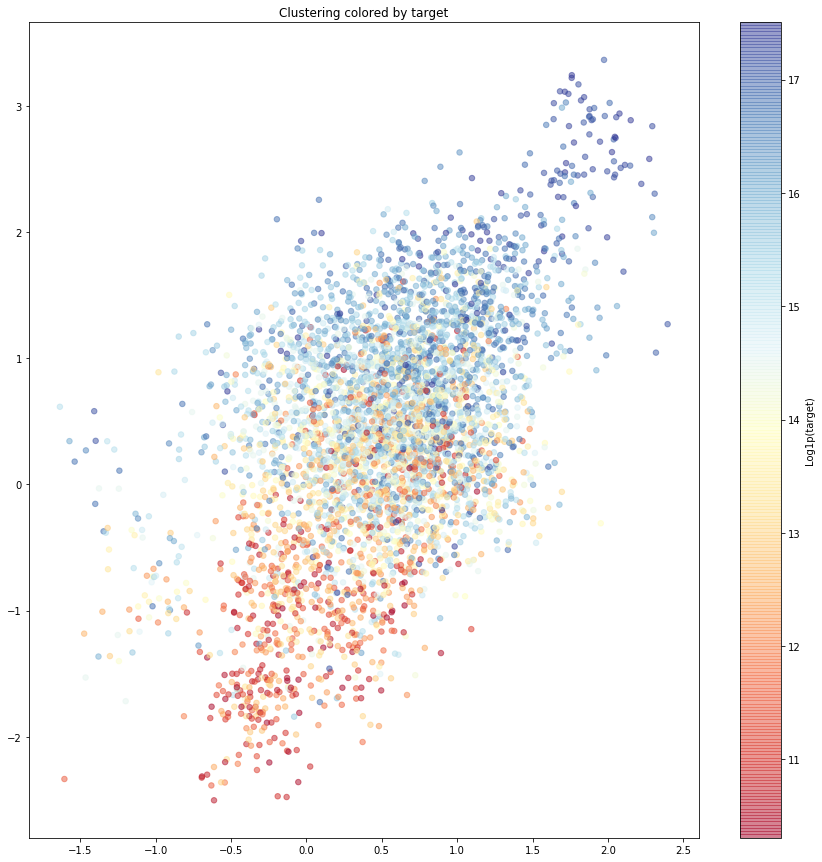

In [10]:
cm = plt.cm.get_cmap('RdYlBu')
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
sc = axes.scatter(gpdata[:,0], gpdata[:,1], alpha=.5, c=(gpdata[:,2]), cmap=cm, s=30)
cbar = fig.colorbar(sc, ax=axes)
cbar.set_label('Log1p(target)')
_ = axes.set_title("Clustering colored by target")

In [11]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(gpdata)):
    trn_x, trn_y = gpdata[trn_idx,0:2], gpdata[trn_idx,-1]
    val_x, val_y = gpdata[val_idx,0:2], gpdata[val_idx,-1]
    
       
    clf = KNeighborsRegressor(n_neighbors=100)
    clf.fit(trn_x,trn_y)
    score = np.sqrt(mean_squared_error(val_y,clf.predict(val_x)))
    print('Fold:', n_fold,score)
    scores.append(score)
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
print('Mean Score:',np.mean(scores))
print('Std Score:',np.std(scores))

Fold: 0 1.3803063978791308
Fold: 1 1.4705165405654639
Fold: 2 1.4166506690255927
Fold: 3 1.410821410360033
Fold: 4 1.3531727395576056
Mean Score: 1.4062935514775652
Std Score: 0.03936881133214944


In [12]:
x1 = GPClusterX(traindf)
x2 = GPClusterY(traindf)
gptraindata = np.hstack([x1.reshape(-1,1),x2.reshape(-1,1)])
x1 = GPClusterX(testdf)
x2 = GPClusterY(testdf)
gptestdata = np.hstack([x1.reshape(-1,1),x2.reshape(-1,1)])

test_preds = np.zeros(testdf.shape[0])
traindata = np.hstack([traindf.values,gptraindata])
testdata = np.hstack([testdf.values,gptestdata])

In [13]:
xgb_params = {
        'n_estimators': 360,
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 5,
        'min_child_weight': 100,#57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': 15,
        'random_state': 456
    }

fit_params = {
    'eval_metric': 'rmse',
    'verbose': False
}

clf = xgb.XGBRegressor(**xgb_params).fit(
                traindata, y_train_log,
                **fit_params
            )
       
clf.fit(traindata,y_train_log)
score = np.sqrt(mean_squared_error(y_train_log,clf.predict(traindata)))
print(score)
test_preds = clf.predict(testdata)

submission = pd.DataFrame()
submission['ID'] = id_test
submission['target'] = np.expm1(test_preds)
submission.to_csv('sergeipluscluster.csv', index=None)

1.2079145716751685


In [14]:
traindata.dump('santander-gp-clustering-ii.trainfeatures.pkl')

In [15]:
testdata.dump('santander-gp-clustering-ii.testfeatures.pkl')

In [39]:
def get_20_cv_splits(data):
    #stratify_classes = y
    train = pd.read_csv(os.path.join(PATH_TO_DATA, 'input/train.csv'), usecols=['target'])
    stratify_classes =  train.target.apply(lambda x: int(np.log10(x)))
    splits = {}
    for random_state in range(20):
        column = np.zeros(data.shape[0])
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)
        for i, (_, test_index) in enumerate(sss.split(data, stratify_classes)):
            column[test_index] = i

        splits["split{}".format(random_state)] = column

    pd.DataFrame(splits, index=data.index).to_csv(os.path.join(PATH_TO_DATA, 'cv_splits_cleandata_stat_bin_red.csv'))
    # function to generate 100 folds from create_folds_from_cv_splits func
def create_folds_from_cv_splits(in_path):
    
    cv_splits = pd.read_csv(os.path.join(PATH_TO_DATA, in_path))
    folds_list = []
    for ind, i in enumerate(cv_splits.columns[1:]):
        folds = list(set(cv_splits[i].values))
        folds_list.append([])
        for m in folds:
            val_idx = list(cv_splits[cv_splits[i]==m].index)
            train_idx = list(set(list(cv_splits.index)) - set(val_idx))
            folds_list[ind].append((train_idx, val_idx))
    with open(os.path.join(PATH_TO_DATA, 'custom_cv.pkl'), 'wb') as f:
        pickle.dump(folds_list, f)
    return folds_list

In [40]:
import xgboost as xgb

def run_xbg(train_X, train_y, val_X, val_y, test_X):
    xgb_params = {
            'n_estimators': 360,
            'objective': 'reg:linear',
            'booster': 'gbtree',
            'learning_rate': 0.02,
            'max_depth': 5,
            'min_child_weight': 100,#57,
            'gamma' : 1.45,
            'alpha': 0.0,
            'lambda': 0.0,
            'subsample': 0.67,
            'colsample_bytree': 0.054,
            'colsample_bylevel': 0.50,
            'n_jobs': 15,
            'random_state': 456
        }

    fit_params = {
        'eval_metric': 'rmse',
        'verbose': False
    }
    model = xgb.XGBRegressor(**xgb_params).fit(
                train_X, train_y,
                **fit_params
            )
    '''
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
        
    model = xgb.train(xgb_params,tr_data,watchlist, early_stopping_rounds = 100,   
                
            )
    '''
    print('Model training done in {} seconds.'.format(time.time() - start_time))
    
    pred_test_y = np.expm1(model.predict(test_X)).ravel()
    pred_oof_log = model.predict(val_X).ravel()
    return pred_test_y, pred_oof_log, model

In [44]:
def run_calculations(X, test, big_cv_folds, func_name = None):
    if 1 != 1:
        return print('The function to run is not defined')
    else:
        y_oof_20_preds = []
        fold_errors_20_preds =[]
        avg_test_pred_20_preds = []
        
        for ind, cv_folds in enumerate(big_cv_folds):
            print('Fitting big fold', ind+1, 'out of', len(big_cv_folds))
            y_oof = np.zeros((y.shape[0]))
            fold_errors =[]
            pred_test_list = []
            
            for i, (train_index, val_index) in enumerate(cv_folds):
                print('Fitting sub fold', i+1, 'out of', len(cv_folds))
                X_train, X_val  = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y[train_index], y[val_index]

                # part to include additional functions
                if func_name == 'xgb':
                    print(X_train.shape, y_train.shape, y_train.shape, X_val.shape)
                    pred_test_y, pred_oof_log, clf = run_xbg(X_train, y_train, X_val, y_val, test)
                else:
                    return print('The function to run is not correct')

                y_oof[val_index] = pred_oof_log
                curr_fe = np.sqrt(mean_squared_error(y_val, pred_oof_log))
                print(f'Fold error {curr_fe}')
                fold_errors.append(curr_fe)
                pred_test_list.append(list(pred_test_y))

            print('Total error', np.sqrt(mean_squared_error(y, y_oof)))
            total_fe_std = round(np.std(fold_errors), 5)
            print(f'Total std {total_fe_std}')
            avg_test_pred = np.mean(pred_test_list, axis=0)
            
            avg_test_pred_20_preds.append(avg_test_pred)
            fold_errors_20_preds.append(fold_errors)
            y_oof_20_preds.append(y_oof)
            
        return y_oof_20_preds, avg_test_pred_20_preds, fold_errors_20_preds  


In [45]:
%%time
import time
start_time = time.time()

# "feature_fraction" : 0.1, 'max_depth': 8

y = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'), usecols=['target'])
y = np.log1p(y.target.values)

y_oof_lgb, pred_test_list_lgb, fold_errors = run_calculations(traindata, testdata, cv_folds, 'xgb')


Fitting big fold 1 out of 20
Fitting sub fold 1 out of 5
(2653, 276) (2653,) (2653,) (1806, 276)
Model training done in 0.6516749858856201 seconds.
Fold error 1.325322839017564
Fitting sub fold 2 out of 5
(4001, 276) (4001,) (4001,) (458, 276)
Model training done in 1.1375882625579834 seconds.
Fold error 1.2934485279383274
Fitting sub fold 3 out of 5
(3882, 276) (3882,) (3882,) (577, 276)
Model training done in 1.5895750522613525 seconds.
Fold error 1.3037055534177497
Fitting sub fold 4 out of 5
(3733, 276) (3733,) (3733,) (726, 276)
Model training done in 2.038695812225342 seconds.
Fold error 1.3809167618395142
Fitting sub fold 5 out of 5
(3567, 276) (3567,) (3567,) (892, 276)
Model training done in 2.4628891944885254 seconds.
Fold error 1.3305618577502483
Total error 1.3295984759660784
Total std 0.0303
Fitting big fold 2 out of 20
Fitting sub fold 1 out of 5
(2632, 276) (2632,) (2632,) (1827, 276)
Model training done in 3.362825393676758 seconds.
Fold error 1.3661528747137326
Fitting

Model training done in 24.79610562324524 seconds.
Fold error 1.3392036765218693
Fitting sub fold 2 out of 5
(3992, 276) (3992,) (3992,) (467, 276)
Model training done in 25.256078243255615 seconds.
Fold error 1.2977126213484662
Fitting sub fold 3 out of 5
(3872, 276) (3872,) (3872,) (587, 276)
Model training done in 25.696656942367554 seconds.
Fold error 1.2898784723409684
Fitting sub fold 4 out of 5
(3752, 276) (3752,) (3752,) (707, 276)
Model training done in 26.241826057434082 seconds.
Fold error 1.3205426356453915
Fitting sub fold 5 out of 5
(3567, 276) (3567,) (3567,) (892, 276)
Model training done in 26.87509059906006 seconds.
Fold error 1.3538469813025245
Total error 1.3285162579905252
Total std 0.02416
Fitting big fold 12 out of 20
Fitting sub fold 1 out of 5
(2624, 276) (2624,) (2624,) (1835, 276)
Model training done in 27.318190336227417 seconds.
Fold error 1.3082158635580214
Fitting sub fold 2 out of 5
(4006, 276) (4006,) (4006,) (453, 276)
Model training done in 28.05314373

In [18]:
traindata = pd.DataFrame(traindata)
testdata = pd.DataFrame(testdata)

In [29]:
import os
from sklearn.model_selection import StratifiedShuffleSplit 
import pickle

LOAD_CV = True
PATH_TO_DATA =''
if LOAD_CV:
    with open(os.path.join(PATH_TO_DATA, 'custom_cv.pkl'), 'rb') as f:
        cv_folds = pickle.load(f)
else:
    get_20_cv_splits(traindata)
    cv_folds = create_folds_from_cv_splits(in_path='folds/cv_splits_cleandata_stat_bin_red.csv')

In [19]:
print('Length of test predictions:', len(pred_test_list_lgb))
avg_pred_test_list_lgb = np.mean(pred_test_list_lgb, axis=0)
print('Length of avg test predictions:', len(avg_pred_test_list_lgb))

NameError: name 'pred_test_list_lgb' is not defined

In [53]:
#Total error 1.3326720367377376
#Total std 0.02142
# 20x oof train preds
with open(os.path.join(PATH_TO_DATA, 'folds/20folds_train_xgb_gp_clus_cv133_std0021.pkl'), 'wb') as f:
    pickle.dump(y_oof_lgb, f)
    
#20x test preds
with open(os.path.join(PATH_TO_DATA, 'folds/20folds_test_xgb_gp_clus_cv133_std0021.pkl'), 'wb') as f:
    pickle.dump(pred_test_list_lgb, f)